# Random Walk Sampling (RWS) and Induced Random Walk Sampling (IRWS)

#### Matheus Victal Cerqueira, _Universidade de São Paulo_ , [_Instituto de Ciências Matemáticas e de Computação_](https://www.icmc.usp.br/). 


The ideas involved in the production of this notebook are based in the following paper: _Ribeiro, Bruno, and Don Towsley. "Estimating and sampling graphs with multidimensional random walks." Proceedings of the 10th ACM SIGCOMM conference on Internet measurement. 2010._

### Random Walk Sampling (RWS)

Random walk methods are extremely insightful for the understanding of topology and dynamics on networks. Here, we explore its use for sampling on graphs, specially in cases where the final goal is _down scaling_ the topology of a given network. In a nutshell, random walk sampling consists in performing a random walk on a graph of interest, sampling edges from the random walkers path. First, we will discuss the Random Walk Sampling (RWS) on its simplest form, and then, we'll proceed to discuss a induced graph sampling technique, the Induced Random Walk Sampling (IRWS).

For starters, let's imagine we have a sampling budget _B_ and a graph of interest $G(V,E)$. In the random walk sampling, the random walker will have to "work with" the budget that it was given. Once the budget finds its end, so does the sampling process.

The random walker begins the procedure in a random vertex $v_0 \in V$, from which it chooses an edge $(v_0, u_0) \in E$ uniformly from all possible edges connected to $v_0$. Once the random walker chooses an edge, it walks to $u_0$ continuing the process, now by choosing an edge $(v_1, u_1) \in E, v_1 = u_0$ using the same criteria as before. When the budget finds its limit, we are left with a sequence $\mathcal{S} = \{(v_i, u_i)\}_{i=1}^{B}$ of sampled edges, where $u_i = v_{i-1}, i = 2,3,\cdots,B$.


### A Random Walk Sampling suggested algorithm

Now, lets discuss an algorithm to perform such sampling. The following routine is developed in python and the following libraries and functions are necessary for the implementation.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import networkx as nx
import random as rd
from collections import Counter

The following routine implements the idea that was presented previsously. After it will be presented a suggested implementation to use when comparing graph sampling methods in a computational manner, hence, the function bellow will be indentified as _pure_RWS_.

In [70]:
# pure_RWS receives the networkx graph of interest G and the budget B
def pure_RWS(G, B):
    import random as rd

    sampled_node = rd.sample(G.nodes,1) # sampling the node that will start the random walk (returns [node_label])
    
    # Auxiliar variables:
    # sampled_node is a list, not a number, we need a hashable variable for the method .neighbors
    current = sampled_node[0] 
    next_ = 0
    count = 0 # keeps track of the budget that's left
    edgelist = []
    
    while count<B:
        neighbors = list(G.neighbors(current)) # turn the current node neighbors iterators into a list
        next_ = rd.choice(neighbors) # uniform random choice from neighbors
        edgelist.append((current,next_)) # sampled edge
        current = next_
        
        count = count + 1
        
    sampled_graph = nx.Graph(edgelist) # builds a nx.Graph object to store the sampled subgraph, mantaining the original labels
    
    return sampled_graph

Now, let's see how the function performs in a [random Barabási Albert graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html). We will use the visualization function bellow to better understand how the function is sampling.

In [71]:
def visualize(G, sample = 0):
    
    if sample == 0:
        pos=nx.spring_layout(G)
        plt.figure(figsize=(15,9))
        nx.draw_networkx(G, node_size=75, with_labels = False ,font_size=16, pos=pos,node_color='royalblue',edge_color ='k') 
        plt.show(True)
        
    else:
        pos=nx.spring_layout(G)
        plt.figure(figsize=(15,9))
        nx.draw_networkx(G, node_size=75, with_labels = False ,font_size=16, 
                         pos=pos,node_color='royalblue',edge_color ='royalblue') 
        nx.draw_networkx(sample, node_size=150, with_labels = False ,font_size=16, 
                         pos=pos,node_color='k',edge_color ='k',width = 2)
        plt.show(True)
        
    return

In [72]:
G = nx.barabasi_albert_graph(100, 1, seed = 2112)

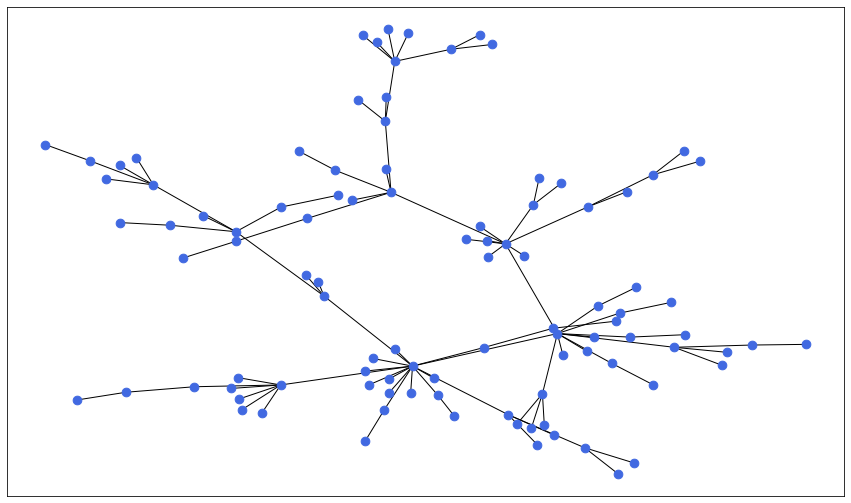

In [73]:
visualize(G)

Considering a sampling process where the budget $B$ is 30, bellow we perform the pure RWS. Let $g$ be the sampled subgraph form $G$.

In [74]:
B = 30

g = pure_RWS(G,B)

Using the function _visualize_, it is possible to see the sampled graph projected in the original graph. $G$ (vertices and edges) is represented in royal blue and $g$ (vertices and edges) is represented in black

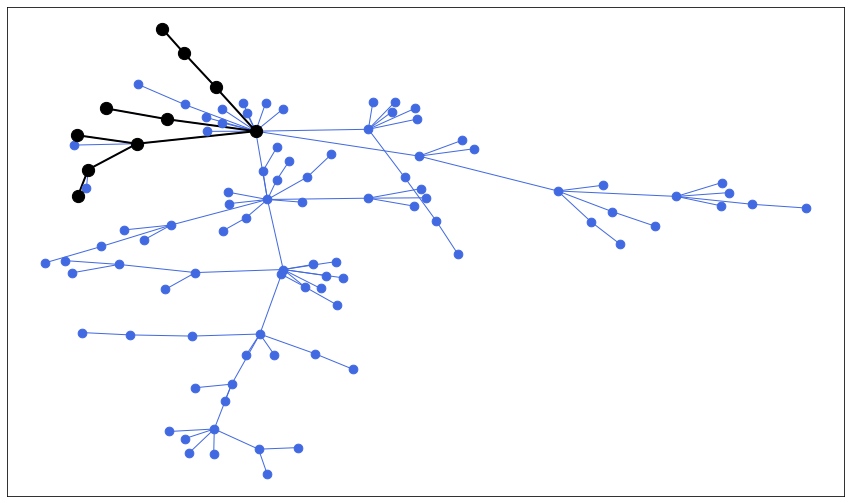

In [75]:
visualize(G,g)

In [76]:
len(g)

10

It is notorious that the sample does not represent very well the graph, and the sampled subgraph has less that 30 nodes. Let's increase $B$ and see what happens.

Sample size: 18


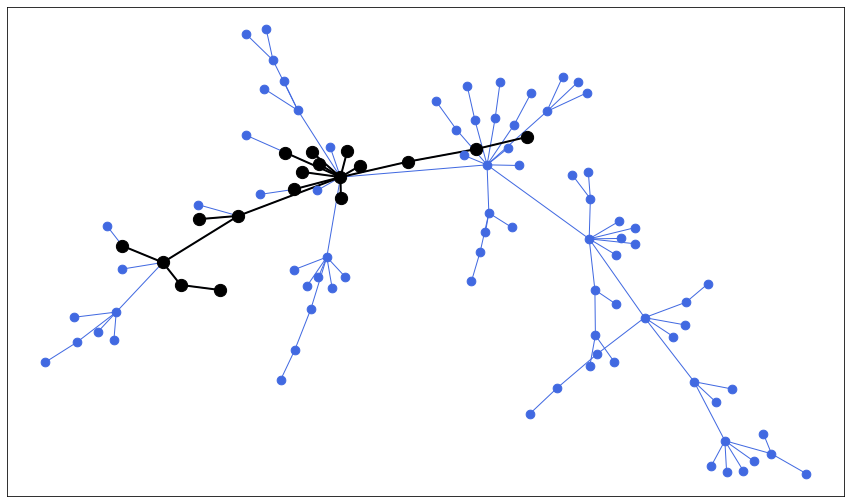

In [77]:
B = 60

g = pure_RWS(G,B)

print("Sample size:", len(g))

visualize(G,g)

The _pure_RWS_ function is interesting to investigate how random walks can be used to sample a graph. But when it comes to comparing different graph sampling methods and their properties, it can be not as suitable, as we can not control the absolute size of the sample (number of different edges sampled) $\nu (\mathcal{S})$, given that $Var[\nu(\mathcal{S})]\neq 0$ with this specific sampling plan. With that in mind, let us change the function to return a controlable sample absolute size in regard to the nodes. It will be also included a new featrue: a rewinding probability $r$.

following python function perfoms the RWS by receiving a networkx graph object $G$ of interest, a sampling budget of $n$ **different** nodes (note that here we are interested in the size of the list of sampled nodes, and not sampled edges) and a rewinding probability $r$, returning a sampled subgraph of the original network. Using the [random](https://docs.python.org/3/library/random.html) python library, the function chooses ramdomly a vertex to start the random walk, defined as sampled_node. After defining auxiliar variables, the function proceeds to perform the random walk in a _while_ loop, that is not broken until the number of intended sampled nodes $n$ is achieved. In every iteration, there is a probability $r$ of rewinding for the stochastic process, in other words, in every step the random walker has a probability $r$ of returning to the initial vertex sampled_node ($r=0$ by default). The size of the sampled nodes list is tracked in each iteration using the function [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) from the module [collections](https://docs.python.org/3/library/collections.html#module-collections).

In [78]:
# RWS function receives G, n and r (default = 0)
def RWS(G, n, r=0):
    import random as rd

    sampled_node = rd.sample(G.nodes,1) # sampling the node that will start the random walk (returns [node_label])
    
    # Auxiliar variables:
    # sampled_node is a list, not a number, we need a hashable variable for the method .neighbors
    current = sampled_node[0] 
    next_ = 0
    count = 0 # stores the number of sampled nodes
    edgelist = [] # stores sampled edges
    node_list = [] # stores sampled nodes
    node_list.append(current)
    
    # Random walk loop:
    while count<n:
        neighbors = list(G.neighbors(current)) # turn the current node neighbors iterators into a list
        next_ = rd.choice(neighbors) # uniform random choice from neighbors
        edgelist.append((current,next_)) # sampled edge
        node_list.append(next_) # sampled node
        
        # Applying the rewinding probability (rd.random = X ~ U[0,1] , F(x) = x)
        u = rd.random()
        if u < r:
            current = sampled_node[0]
        else:
            current = next_
            
        count = len(Counter(node_list).keys()) # sample size verification
        
    sampled_graph = nx.Graph(edgelist) # builds a nx.Graph object to store the sampled subgraph, mantaining the original labels
    
    return sampled_graph

Considering the new function, let's create a more complex random graph to analize.

In [94]:
G = nx.barabasi_albert_graph(100, 2, seed = 2112)

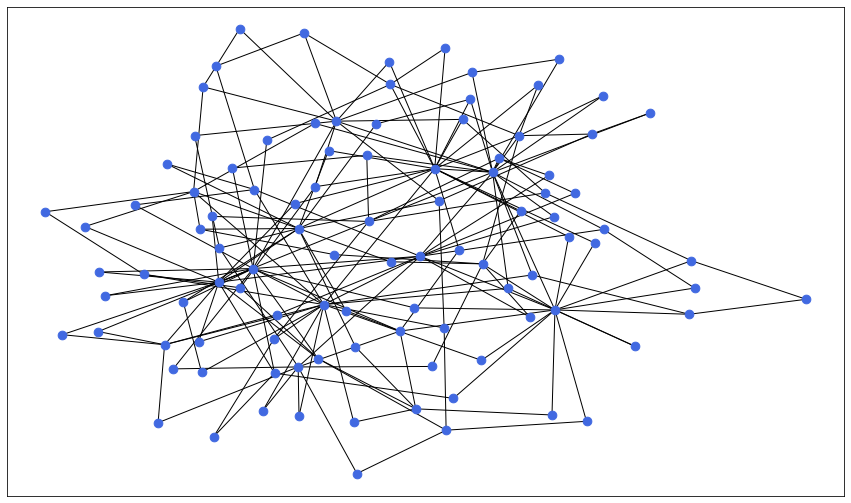

In [95]:
visualize(G)

Let's say we want a sample graph with absolute $n = 50$ nodes. 

In [96]:
n=50

Sample size: 50


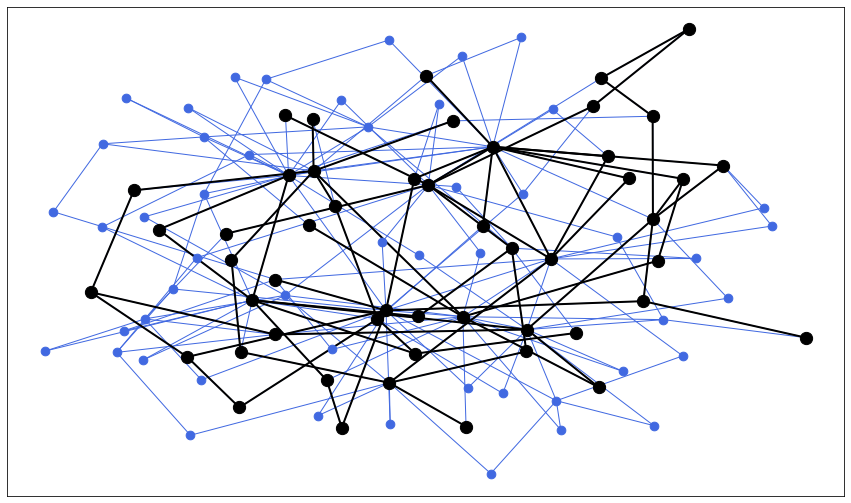

In [97]:
g = RWS(G, n)
print("Sample size:", len(g))
visualize(G,g)

Considering a rewind probability.

Sample size: 50


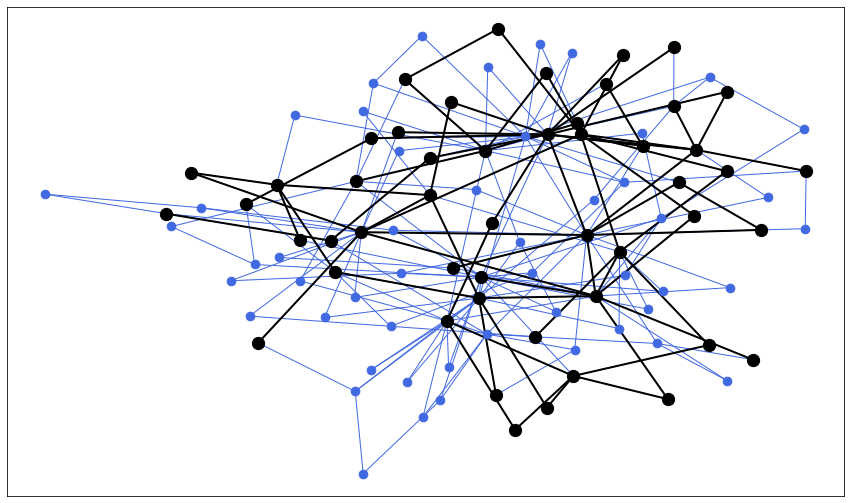

In [98]:
g = RWS(G, n, r = 0.2)
print("Sample size:", len(g))
visualize(G,g)

Note that now the absolute size is controlable. The problem is that the budget $B$ is now unpredictable. In computational implementations, $B$ is related to the number of iterations we are willing to make. So it translates in computational complexity. If we have a graph of interest that is not easily navigalbe by random walks, we can have complexity problems, as the sample is not growing in a desired rate. The function can be changed to support many practical use cases, but its basis is the same.

### Induced Random Walk Sampling (IRWS)

The IRWS is a slightly different approach to sampling using random walks. The walker procedure is the same as RWS, but now, the edges are not sampled during the walks, but induced from the original graph utilizing the list of visited nodes in the random walk.

The process starts by the uniform random choice of a initial vertex $v_0 \in V$ from a graph of interest $G(V,E)$. Fixing a sampling budget $B$, the sampling process is now made on the vertices. The radom walker chooses uniformly a new vertex $v_1$ that is a neghbor of vertex $v_0$ and continues the process using the same criteria. After the budget meets its end, we are left with a sequence $\mathcal{S} = \{v_i\}_{i=0}^{B}$ of sampled nodes. From the list of sample nodes, we take the induced graph in regard to $G$, and the result is an induced subgraph that we take as a sample. In other words, a random walk is performed and the visited vertices are sampled after $B$ steps. Then, an induced subgraph $G[\mathcal{S}]$ is taken as our sample form $G$.

### An Induced Random Walk Sampling suggested algorithm

If we implement the algorithm described above, we will end with the same issue as the _pure_RWS_ function: we can not control the samples absolute size $\nu$ in terms of vertices. So, we will implement a function similar to the _RWS_ function to perform the IRWS. 

In [103]:
# IRWS function receives G, n and r (default = 0)
def IRWS(G, n, r=0):
    from collections import Counter
    import random as rd
    
    sampled_node = rd.sample(G.nodes,1) # sampling the node that will start the random walk (returns [node_label])
    
    # Auxiliar variables:
    # sampled_node is a list, not a number, we need a hashable variable for the method .neighbors
    current = sampled_node[0]
    next_ = 0
    count = 0 # stores the number of sampled nodes
    node_list = [] # stores sampled nodes
    node_list.append(current)
    
    # Random walk loop:
    while count<n:
        neighbors = list(G.neighbors(current)) # turn the neighbors iterators into a list
        next_ = rd.choice(neighbors) # uniform random choice from neighbors
        node_list.append(next_)
        
        # Applying the rewinding probability (rd.random = X ~ U[0,1] , F(x) = x)
        u = rd.random() 
        if u < r:
            current = sampled_node[0]
        else:
            current = next_
        
        count = len(Counter(node_list).keys()) # sample size verification
        
    sampled_graph = G.subgraph(node_list) # obtain the induced subgraph of G from the list node_list of vertices
    
    return sampled_graph

Let's test some examples to compare the number of nodes and edges on each sampling method (RWS and IRWS).

In [110]:
n = 50 

g = IRWS(G,n)
g2 = RWS(G,n)

print("IRWS")
print("Sample size (nodes):", nx.number_of_nodes(g))
print("Sample size (edges):", nx.number_of_edges(g))

print("\nRWS")
print("Sample size (nodes):", nx.number_of_nodes(g2))
print("Sample size (edges):", nx.number_of_edges(g2))

IRWS
Sample size (nodes): 50
Sample size (edges): 91

RWS
Sample size (nodes): 50
Sample size (edges): 71


In [115]:
N = 1000
n = 50 

v_M_IRWS = 0
v_M_RWS = 0

e_M_IRWS = 0
e_M_RWS = 0

for i in range(N):
    g = IRWS(G,n)
    g2 = RWS(G,n)
    
    v_M_IRWS = v_M_IRWS + nx.number_of_nodes(g)
    v_M_RWS = v_M_RWS + nx.number_of_nodes(g2)
    
    e_M_IRWS = e_M_IRWS + nx.number_of_edges(g)
    e_M_RWS = e_M_RWS + nx.number_of_edges(g2)
    
v_M_IRWS = v_M_IRWS/N
v_M_RWS = v_M_RWS/N

e_M_IRWS = e_M_IRWS/N
e_M_RWS = e_M_RWS/N

In [116]:
print("IRWS")
print("Node number mean:", v_M_IRWS)
print("Edge number mean:", e_M_IRWS)
print("\nRWS")
print("Node number mean:", v_M_RWS)
print("Edge number mean:", e_M_RWS)

IRWS
Node number mean: 50.0
Edge number mean: 89.802

RWS
Node number mean: 50.0
Edge number mean: 65.624
